In [127]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset
import networkx as nx
import random
import math
import torch.nn.functional as F

In [128]:
# Device configuration
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

num_agents = 10
epochs = 1000  # Adjusted for demonstration
initial_learning_rate = 0.001
batch_size = 64

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Shuffle and divide data
indices = np.random.permutation(len(dataset))
split_indices = np.array_split(indices, num_agents)
subsets = [Subset(dataset, idx) for idx in split_indices]
dataloaders = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in subsets]

Using device: mps


In [129]:
def initialize_and_make_doubly_stochastic(num_agents, initial_graph_type="erdos_renyi", erdos_renyi_prob=0.8,
                                          tol=1e-5, max_iters=1000, device='cpu'):
    if initial_graph_type == "erdos_renyi":
        G = nx.erdos_renyi_graph(num_agents, erdos_renyi_prob)
        while not nx.is_connected(G):
            G = nx.erdos_renyi_graph(num_agents, erdos_renyi_prob)
    elif initial_graph_type == "complete":
        G = nx.complete_graph(num_agents)
    else:
        print(f"Error: Invalid initial_graph_type: {initial_graph_type}")
        return None, None

    adj_matrix = nx.adjacency_matrix(G).toarray()

    def _make_doubly_stochastic(matrix, tol, max_iters):
        A = matrix.copy().astype(np.float64)
        for _ in range(max_iters):
            new_A = A.copy()
            row_sums = new_A.sum(axis=1)
            if np.any(row_sums == 0):
                new_A[row_sums == 0, :] = 1 / new_A.shape[1]
                row_sums = new_A.sum(axis=1)
            new_A = new_A / row_sums[:, np.newaxis]
            col_sums = new_A.sum(axis=0)
            if np.any(col_sums == 0):
                new_A[:, col_sums == 0] = 1 / new_A.shape[0]
                col_sums = new_A.sum(axis=0)
            new_A = new_A / col_sums
            if np.allclose(new_A.sum(axis=1), 1, atol=tol) and np.allclose(new_A.sum(axis=0), 1, atol=tol):
                return new_A
            A = new_A
        print("Warning: Sinkhorn-Knopp did not converge within max_iters.")
        return A

    W = _make_doubly_stochastic(adj_matrix, tol, max_iters)
    W_tensor = torch.tensor(W, dtype=torch.float32).to(device)
    print(nx.adjacency_matrix(G).toarray())
    print(W_tensor)
    return G, W_tensor

In [130]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def initialize_far_from_optimal(self):
    # Initialize weights with a larger standard deviation
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.normal_(m.weight, mean=0, std=1)  # Larger std
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


def time_varying_graph(G, t, change_prob=0.3, tol=1e-5, max_iters=10000, device='cpu'):
    if t > 0:
        edges = list(G.edges())
        for edge in edges:
            if random.random() < change_prob:
                G.remove_edge(*edge)
        while not nx.is_connected(G):
            u, v = random.sample(range(G.number_of_nodes()), 2)
            G.add_edge(u, v)

    adj_matrix = nx.adjacency_matrix(G).toarray()
    print(f"Adjacency Matrix at t={t}:\n", adj_matrix)

    def _make_doubly_stochastic(matrix, tol, max_iters):
        A = matrix.copy().astype(np.float64)
        for _ in range(max_iters):
            new_A = A.copy()
            row_sums = new_A.sum(axis=1)
            if np.any(row_sums == 0):
                new_A[row_sums == 0, :] = 1 / new_A.shape[1]
                row_sums = new_A.sum(axis=1)
            new_A = new_A / row_sums[:, np.newaxis]
            col_sums = new_A.sum(axis=0)
            if np.any(col_sums == 0):
                new_A[:, col_sums == 0] = 1 / new_A.shape[0]
                col_sums = new_A.sum(axis=0)
            new_A = new_A / col_sums
            if np.allclose(new_A.sum(axis=1), 1, atol=tol) and np.allclose(new_A.sum(axis=0), 1, atol=tol):
                return new_A
            A = new_A
        print("Warning: Sinkhorn-Knopp did not converge within max_iters.")
        return A

    W = _make_doubly_stochastic(adj_matrix, tol, max_iters)
    print(f"Doubly Stochastic Matrix at t={t}:\n", W)
    W_tensor = torch.tensor(W, dtype=torch.float32).to(device)
    return G, W_tensor


In [ ]:
def run_model(epochs, num_agents, losses, models, criterions, initial_learning_rate, use_time_varying_graph=False):
    if use_time_varying_graph:
        G, W = initialize_and_make_doubly_stochastic(num_agents, device=device)
    else:
        G, W = initialize_and_make_doubly_stochastic(num_agents, device=device)

    for epoch in range(epochs):
        if use_time_varying_graph:
            G, W = time_varying_graph(G, epoch, device=device)

        new_params = {}
        for i in range(num_agents):
            new_params[i] = {name: torch.zeros_like(param) for name, param in models[i].named_parameters()}
            for name, param in models[i].named_parameters():
                for j in range(num_agents):
                    new_params[i][name] += W[i, j] * models[j].state_dict()[name]

        for i in range(num_agents):
            for name, param in models[i].named_parameters():
                param.data.copy_(new_params[i][name])

        # learning_rate = initial_learning_rate / (1 + math.log(max(1, epoch)**0.5))

        for i in range(num_agents):
            running_loss = 0.0
            for images, labels in dataloaders[i]:
                images, labels = images.to(device), labels.to(device)
                outputs = models[i](images)
                loss = criterions[i](outputs, labels)
                loss.backward()

                with torch.no_grad():
                    for param in models[i].parameters():
                        param -= learning_rate * param.grad
                    for param in models[i].parameters():
                        param.grad.zero_()

                running_loss += loss.item()
            losses[i].append(running_loss / len(dataloaders[i]))
            print(f"Agent {i+1}, Epoch {epoch+1}, Loss: {running_loss / len(dataloaders[i])}, LR: {learning_rate}")

In [132]:
def get_loss_function(agent_id, num_agents):
    if agent_id % 2 == 0:
        return nn.CrossEntropyLoss()
    else:
        return nn.MSELoss()  

In [ ]:
if __name__ == '__main__':
    models = [CNN().to(device) for _ in range(num_agents)]
    for model in models:
        model.initialize_far_from_optimal()

    criterions = [nn.CrossEntropyLoss() for i in range(num_agents)]

    losses = [[] for _ in range(num_agents)]
    use_time_varying_graph = False

    run_model(epochs, num_agents, losses, models, criterions, initial_learning_rate, use_time_varying_graph)

/var/folders/jj/yj1r8p1s23sgk5x98428488r0000gn/T/ipykernel_1829/2019690034.py:13: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G).toarray()
/var/folders/jj/yj1r8p1s23sgk5x98428488r0000gn/T/ipykernel_1829/2019690034.py:37: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  print(nx.adjacency_matrix(G).toarray())


[[0 1 1 1 1 1 1 0 1 1]
 [1 0 1 0 1 1 1 0 1 1]
 [1 1 0 0 1 1 1 1 0 1]
 [1 0 0 0 0 1 1 1 1 0]
 [1 1 1 0 0 1 0 0 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 0 1 0 1 1 1]
 [0 0 1 1 0 1 1 0 1 1]
 [1 1 0 1 1 1 1 1 0 1]
 [1 1 1 0 1 1 1 1 1 0]]
tensor([[0.0000, 0.1308, 0.1227, 0.1901, 0.1568, 0.0883, 0.1037, 0.0000, 0.0999,
         0.1078],
        [0.1308, 0.0000, 0.1570, 0.0000, 0.2007, 0.1130, 0.1327, 0.0000, 0.1278,
         0.1380],
        [0.1227, 0.1570, 0.0000, 0.0000, 0.1883, 0.1060, 0.1245, 0.1722, 0.0000,
         0.1294],
        [0.1901, 0.0000, 0.0000, 0.0000, 0.0000, 0.1643, 0.1930, 0.2668, 0.1858,
         0.0000],
        [0.1568, 0.2007, 0.1883, 0.0000, 0.0000, 0.1355, 0.0000, 0.0000, 0.1533,
         0.1655],
        [0.0883, 0.1130, 0.1060, 0.1643, 0.1355, 0.0000, 0.0896, 0.1239, 0.0863,
         0.0932],
        [0.1037, 0.1327, 0.1245, 0.1930, 0.0000, 0.0896, 0.0000, 0.1456, 0.1014,
         0.1094],
        [0.0000, 0.0000, 0.1722, 0.2668, 0.0000, 0.1239, 0.1456, 0.0000, 0.1

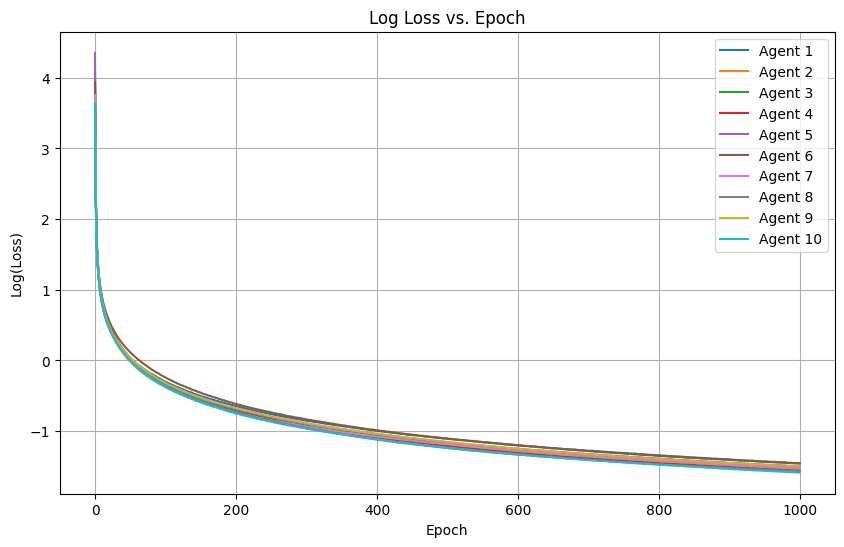

In [ ]:
plt.figure(figsize=(10, 6))  
for i in range(num_agents):
    plt.plot(np.log(losses[i]), label=f"Agent {i+1}")  # Apply log *here*

plt.xlabel("Epoch")
plt.ylabel("Log(Loss)")  
plt.title("Log Loss vs. Epoch")
plt.legend()
plt.grid(True)  
plt.show()

plot, step size decay, initalization 